In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('dataset')

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)


In [4]:
labels

0        Covid19 Negative
1        Covid19 Negative
2        Covid19 Negative
3        Covid19 Negative
4        Covid19 Negative
               ...       
13803    Covid19 Positive
13804    Covid19 Positive
13805    Covid19 Positive
13806    Covid19 Positive
13807    Covid19 Positive
Name: Label, Length: 13808, dtype: object

In [5]:
image_df

,Filepath,Label
0,dataset\Covid19 Negative\Normal-1.png,Covid19 Negative
1,dataset\Covid19 Negative\Normal-10.png,Covid19 Negative
2,dataset\Covid19 Negative\Normal-100.png,Covid19 Negative
3,dataset\Covid19 Negative\Normal-1000.png,Covid19 Negative
4,dataset\Covid19 Negative\Normal-10000.png,Covid19 Negative
...,...,...
13803,dataset\Covid19 Positive\COVID-995.png,Covid19 Positive
13804,dataset\Covid19 Positive\COVID-996.png,Covid19 Positive
13805,dataset\Covid19 Positive\COVID-997.png,Covid19 Positive
13806,dataset\Covid19 Positive\COVID-998.png,Covid19 Positive


In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 8285 validated image filenames belonging to 2 classes.
Found 2071 validated image filenames belonging to 2 classes.
Found 3452 validated image filenames belonging to 2 classes.


In [10]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/20
259/259 [==============================] - 154s 595ms/step - loss: 0.5862 - accuracy: 0.7368 - val_loss: 0.5647 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 157s 607ms/step - loss: 0.5459 - accuracy: 0.7389 - val_loss: 0.5403 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 157s 607ms/step - loss: 0.5377 - accuracy: 0.7403 - val_loss: 0.5268 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 158s 608ms/step - loss: 0.5339 - accuracy: 0.7477 - val_loss: 0.5484 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 157s 607ms/step - loss: 0.5343 - accuracy: 0.7517 - val_loss: 0.5283 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 157s 607ms/step - loss: 0.5315 - accuracy: 0.7537 - val_loss: 0.5272 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 7/20
259/259 [==========================

In [12]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.53882
Test Accuracy: 73.73%


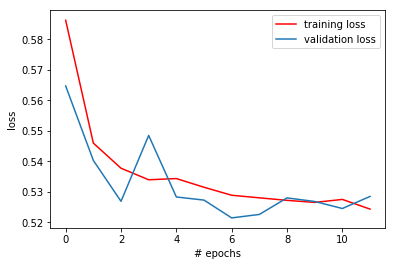

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

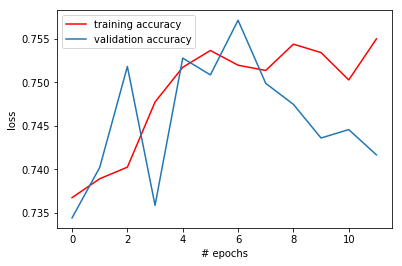

In [14]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


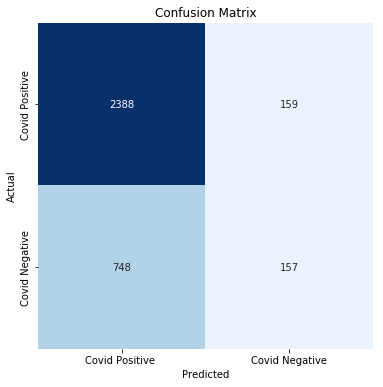

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.76      0.94      0.84      2547
         DOG       0.50      0.17      0.26       905

   micro avg       0.74      0.74      0.74      3452
   macro avg       0.63      0.56      0.55      3452
weighted avg       0.69      0.74      0.69      3452



In [16]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["Covid Positive ", "Covid Negative"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Covid Positive ", "Covid Negative"])
plt.yticks(ticks=[0.5, 1.5], labels=["Covid Positive", "Covid Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [19]:
from tensorflow.keras.models import load_model

model.save('xraymodel.h5')
from tensorflow.keras.models import load_model
 
# load model
# model = load_model('model_rcat_dog.h5')